In [61]:
import os
os.sys.path.append("../")
import re
import math
from itertools import combinations
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
from typing import Union
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FixedLocator
from matplotlib.figure import figaspect
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import anndata as ad
import seaborn as sns
import networkx as nx

import MSDiversity as msd
from tqdm import tqdm 
import utils


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

In [3]:
patient_condition = {'CLR':1, 'DII':2}

# Helper Functions

In [4]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [5]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [6]:
def calculate_interactions(dataframe):
    interactions = {}
    all_cell_types = set(dataframe.columns.get_level_values(0).unique().tolist() + dataframe.columns.get_level_values(1).unique().tolist())
    
    for cell_type in all_cell_types:
        # Find all columns where the cell type is present
        related_columns = (dataframe.columns.get_level_values(0) == cell_type) | (dataframe.columns.get_level_values(1) == cell_type)
        
        # Get the unique cell types interacting with the given cell type
        interacting_cell_types = set(dataframe.columns[related_columns].get_level_values(0).unique().tolist() + dataframe.columns[related_columns].get_level_values(1).unique().tolist())
        
        # Remove the cell type itself from the set of interacting cell types
        interacting_cell_types.discard(cell_type)
        
        # Store the number of unique interacting cell types
        interactions[cell_type] = len(interacting_cell_types)
    
    return interactions

# Read Data

In [7]:
data_dir = '/Users/Emrys/Dropbox/spatial_augmentation/data/CRC_related/crc_codex/'
results_dir = './results_crc'

# Load data
protein = pd.read_csv(os.path.join(data_dir, 'CRC_clusters_neighborhoods_markersV2.csv')) # ~258,000 codex cells

In [8]:
protein = protein[~protein['ClusterName'].str.contains('dirt')]
# protein = protein[~protein['ClusterName'].str.contains('undefined')]

In [24]:
for col in protein.columns:
    print(col)

Unnamed: 0.1
Unnamed: 0
CellID
ClusterID
EventID
File Name
Region
TMA_AB
TMA_12
Index in File
groups
patients
spots
CD44 - stroma:Cyc_2_ch_2
FOXP3 - regulatory T cells:Cyc_2_ch_3
CD8 - cytotoxic T cells:Cyc_3_ch_2
p53 - tumor suppressor:Cyc_3_ch_3
GATA3 - Th2 helper T cells:Cyc_3_ch_4
CD45 - hematopoietic cells:Cyc_4_ch_2
T-bet - Th1 cells:Cyc_4_ch_3
beta-catenin - Wnt signaling:Cyc_4_ch_4
HLA-DR - MHC-II:Cyc_5_ch_2
PD-L1 - checkpoint:Cyc_5_ch_3
Ki67 - proliferation:Cyc_5_ch_4
CD45RA - naive T cells:Cyc_6_ch_2
CD4 - T helper cells:Cyc_6_ch_3
CD21 - DCs:Cyc_6_ch_4
MUC-1 - epithelia:Cyc_7_ch_2
CD30 - costimulator:Cyc_7_ch_3
CD2 - T cells:Cyc_7_ch_4
Vimentin - cytoplasm:Cyc_8_ch_2
CD20 - B cells:Cyc_8_ch_3
LAG-3 - checkpoint:Cyc_8_ch_4
Na-K-ATPase - membranes:Cyc_9_ch_2
CD5 - T cells:Cyc_9_ch_3
IDO-1 - metabolism:Cyc_9_ch_4
Cytokeratin - epithelia:Cyc_10_ch_2
CD11b - macrophages:Cyc_10_ch_3
CD56 - NK cells:Cyc_10_ch_4
aSMA - smooth muscle:Cyc_11_ch_2
BCL-2 - apoptosis:Cyc_11_ch_3
CD25 - I

In [9]:
CLR_files = protein.loc[protein['groups'] == 1, 'File Name',].unique().tolist()
DII_files = protein.loc[protein['groups'] == 2, 'File Name',].unique().tolist()
library_ids = [CLR_files,DII_files]

In [10]:
patient_ids = list(range(1, 36))
patient_to_region = {}
region_to_patient = {}
for patient_id in patient_ids:
    region_ids = []
    base_id = patient_id * 2
    region_ids.append(f"reg{str(base_id-1).zfill(3)}_A")
    region_ids.append(f"reg{str(base_id-1).zfill(3)}_B")
    region_ids.append(f"reg{str(base_id).zfill(3)}_A")
    region_ids.append(f"reg{str(base_id).zfill(3)}_B")
    patient_to_region[patient_id] = region_ids
    for region_id in region_ids:
        region_to_patient[region_id] = patient_id

In [11]:
# Only run this cell to produce cell-type map
print(len(pd.unique(protein['ClusterNameV2'])), flush=True)
protein = protein[~protein['ClusterNameV2'].str.contains('remove')]
bokai_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
                 '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                 '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']
bokai_palette = dict(zip(pd.unique(protein['ClusterNameV2']), bokai_palette))

22


# Reproducing CRC paper figure 6K

In [65]:
protein['ClusterNameV2'].unique()

array(['granulocytes', 'vasculature', 'CD4+ T cells', 'tumor cells',
       'stroma', 'macrophages', 'adipocytes', 'plasma cells',
       'CD8+ T cells', 'Other T cells', 'CD11c+ DCs', 'B cells',
       'smooth muscle', 'remove', 'tumor cells / immune cells',
       'immune cells / vasculature', 'immune cells', 'NK cells', 'nerves',
       'CD68+ macrophages', 'lymphatics', 'CD11b+ monocytes'],
      dtype=object)

In [88]:
protein['neighborhood name'].unique()

array(['Granulocyte enriched', 'Macrophage enriched',
       'Immune-infiltrated stroma', 'T cell enriched',
       'Vascularized smooth muscle', 'Follicle', nan, 'Tumor boundary',
       'Smooth muscle', 'Bulk tumor'], dtype=object)

In [89]:
df_neighborhood9 = protein[(protein['neighborhood name'] == 'Granulocyte enriched') & (protein['groups'] == 2)]

# Step 2: Group the filtered DataFrame by 'patients'
grouped = df_neighborhood9.groupby(['patients'])

# Step 3: Calculate the frequency of CD4+ T cells for each patient
def calculate_cd4_frequency(group):
    total_cells = len(group)
    print(f"number of total cells in CN-9 {total_cells}")
    cd4_cells = group[(group['ClusterName'] == 'CD4+ T cells') & (group['CD4+PD-1+'] == 1)].shape[0]
    print(f"number of PD-1+CD4+ T cells in CN-9 {cd4_cells}")
    frequency = cd4_cells / total_cells if total_cells > 0 else 0
    return pd.Series({'CD4+ T cell frequency in CN-9': frequency})

# Apply the function to each group
frequency_df = grouped.apply(calculate_cd4_frequency).reset_index().rename(columns={'patients':'Patient'})
frequency_df


number of total cells in CN-9 1999
number of PD-1+CD4+ T cells in CN-9 1
number of total cells in CN-9 714
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 2084
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 1369
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 549
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 4413
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 60
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 66
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 79
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 549
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 101
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 103
number of PD-1+CD4+ T cells in CN-9 0
number of total cells in CN-9 513
number of PD-1+CD4+ T cells in CN-9 1
number of total cells in CN-9 209
number of PD-1+CD4+ T cells i

,Patient,CD4+ T cell frequency in CN-9
0,2,0.000500
1,3,0.000000
2,4,0.000000
3,5,0.000000
4,7,0.000000
5,8,0.000000
6,9,0.000000
7,14,0.000000
8,15,0.000000
9,16,0.000000


In [ ]:
meta_path = '/Users/Emrys/Dropbox/spatial_augmentation/data/CRC_related/crc_codex/'
meta_df = pd.read_csv(os.path.join(meta_path, 'CRC_TMAs_patient_annotations.csv'))
meta_df = meta_df.loc[:34]

In [90]:
df_combined = pd.merge(frequency_df[['Patient','CD4+ T cell frequency in CN-9']], meta_df[['Patient','OS','OS_Censor']], on='Patient', how='inner')
df_combined

,Patient,CD4+ T cell frequency in CN-9,OS,OS_Censor
0,2,0.000500,137.640,0.0
1,3,0.000000,0.394,1.0
2,4,0.000000,0.526,1.0
3,5,0.000000,43.458,1.0
4,7,0.000000,68.179,0.0
5,8,0.000000,21.236,1.0
6,9,0.000000,12.788,1.0
7,14,0.000000,13.248,0.0
8,15,0.000000,0.296,1.0
9,16,0.000000,124.622,0.0


Iteration 1, p-value: 0.5072333808189531
Iteration 2, p-value: 0.6398519694058803
Iteration 3, p-value: 0.9115946899443004
Iteration 4, p-value: 0.29391712719914687
Iteration 5, p-value: 0.15223727369585274
Iteration 6, p-value: 0.48136202427175045
Iteration 7, p-value: 0.9886538507516386
Iteration 8, p-value: 0.2592001751037793
Iteration 9, p-value: 0.9180394563457906
Iteration 10, p-value: 0.10758065495645303
Iteration 11, p-value: 0.6679012831889921
Iteration 12, p-value: 0.76806605838479
Iteration 13, p-value: 0.3628965681524102
Iteration 14, p-value: 0.5370532815576431
Iteration 15, p-value: 0.6593284049767025
Iteration 16, p-value: 0.48249306557878335
Iteration 17, p-value: 0.5968758584490226
Iteration 18, p-value: 0.44775741315103124
Iteration 19, p-value: 5.830721022958774e-06
Desired p-value threshold reached at iteration 19
The best p-value is 5.830721022958774e-06


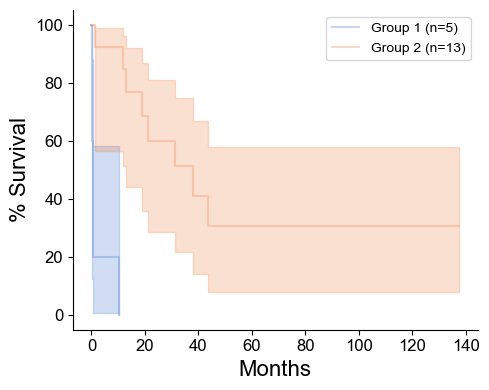

In [107]:
kmf = KaplanMeierFitter()

# Set the desired p-value threshold
p_value_threshold = 0.001  # You can adjust this value as needed

# Maximum number of iterations to prevent infinite loops
max_iterations = 1000

# Initialize variables to store the best p-value and corresponding groups
best_p_value = 1.0
best_group1 = None
best_group2 = None

for iteration in range(1, max_iterations + 1):
    # Randomly select 5 patients as Group 1
    df_group1 = df_combined.sample(n=5, random_state=None)

    # Assign the rest of the patients to Group 2
    df_group2 = df_combined.drop(df_group1.index)

    # Perform the logrank test between the two groups
    result = logrank_test(
        df_group1['OS'], df_group2['OS'],
        event_observed_A=df_group1['OS_Censor'],
        event_observed_B=df_group2['OS_Censor']
    )
    p_value = result.p_value
    print(f"Iteration {iteration}, p-value: {p_value}")

    # Update the best p-value and groups if current p-value is smaller
    if p_value < best_p_value:
        best_p_value = p_value
        best_group1 = df_group1.copy()
        best_group2 = df_group2.copy()

    # Stop the loop if p-value is less than the specified threshold
    if p_value < p_value_threshold:
        print(f"Desired p-value threshold reached at iteration {iteration}")
        break

# Check if a suitable group was found
if best_p_value >= p_value_threshold:
    print(f"No group found with p-value less than {p_value_threshold} after {max_iterations} iterations.")
    print(f"Using the best p-value found: {best_p_value}")
else:
    print(f"The best p-value is {best_p_value}")

# Set the color palette to "muted" and get the colors
sns.set_palette("muted")
colors = sns.color_palette()

# Plot the Kaplan-Meier curves for the two groups
plt.figure(figsize=(5, 4))

# Plot for Group 1
kmf.fit(best_group1['OS'], best_group1['OS_Censor'], label=f'Group 1 (n={len(best_group1)})')
ax = kmf.plot_survival_function(color=colors[0], alpha=0.3)

# Plot for Group 2
kmf.fit(best_group2['OS'], best_group2['OS_Censor'], label=f'Group 2 (n={len(best_group2)})')
kmf.plot_survival_function(ax=ax, color=colors[1], alpha=0.3)

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(FixedLocator(ticks_loc))
ax.set_yticklabels([f'{100 * y:.0f}' for y in ticks_loc])
plt.xlabel('Months', fontsize=16)
plt.ylabel('% Survival', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save and display the plot
save_path = 'CRC_random5_survivalKM.svg'
fig = plt.gcf()
fig.savefig('../figures/crc/' + save_path)
plt.show()
plt.close(fig)


# Determine P-value Cut-off

In [12]:
from pysal.lib import weights
from pysal.explore import esda
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FuncFormatter)

In [30]:
test_sample = 'reg067_A'
test_scale = 32.0

protein_region = protein.loc[protein['File Name'] == test_sample,:]
patches_coordinates = msd.generate_patches(protein, 'File Name', test_sample, scaling_factor=test_scale, spatial_key=['X:X','Y:Y'])

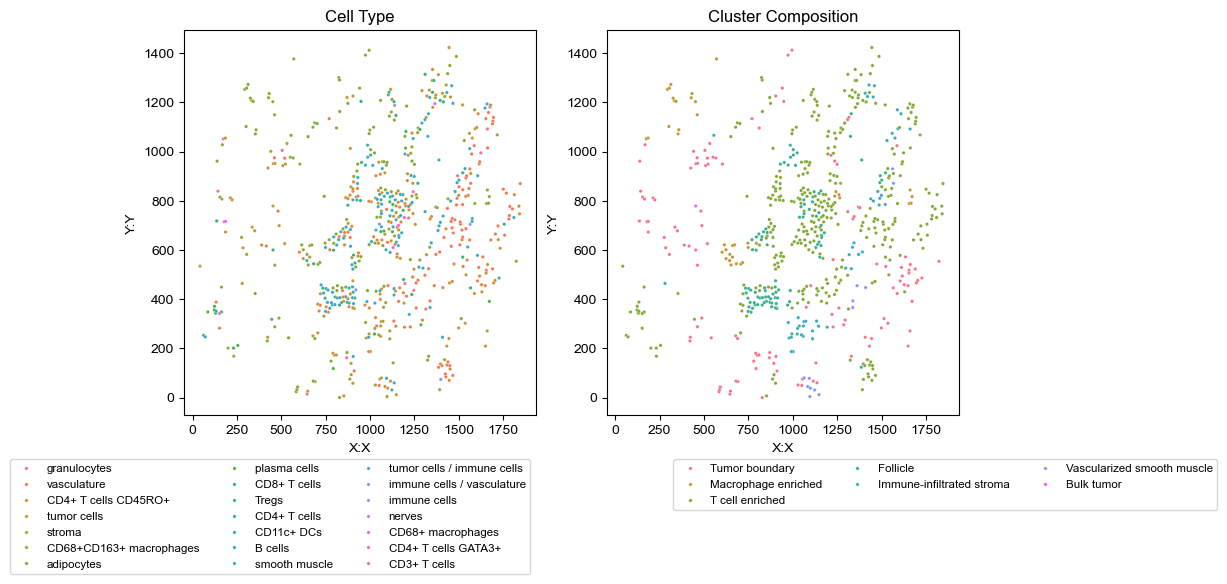

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="ClusterName", palette='husl', s=6, legend='full', ax=axes[0])
axes[0].set_title('Cell Type')
axes[0].legend(bbox_to_anchor=(1.0, -0.1), ncol=3, fontsize='small')

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="neighborhood name", palette='husl', s=6, ax=axes[1])
axes[1].set_title('Cluster Composition')
axes[1].legend(bbox_to_anchor=(1.75, -0.1), ncol=3, fontsize='small')
plt.show()

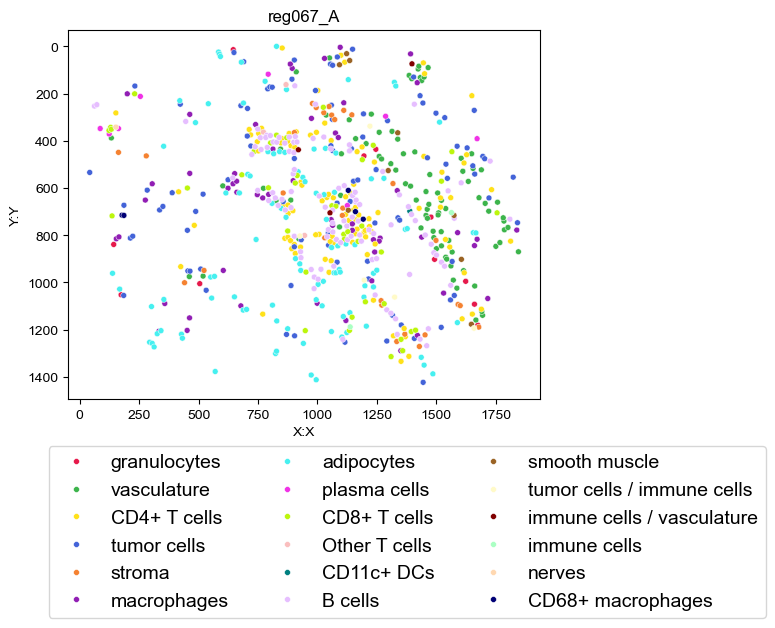

In [32]:
x_coords = protein_region['X:X']
y_coords = protein_region['Y:Y']
width = x_coords.max(axis=0) - x_coords.min(axis=0)
height = y_coords.max(axis=0) - y_coords.min(axis=0)
w, h = figaspect(height/width)
fig, ax = plt.subplots(1, 1, figsize=(w, h))

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="ClusterNameV2", palette=bokai_palette, s=18, legend='full', ax=ax, rasterized=True)
ax.set_title(test_sample)
ax.legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize=14)
ax.invert_yaxis()
save_path = test_sample + '_celltype.svg'
fig.savefig('../figures/crc/'+save_path, dpi=300)
plt.show()

67.480 per cent patches are empty


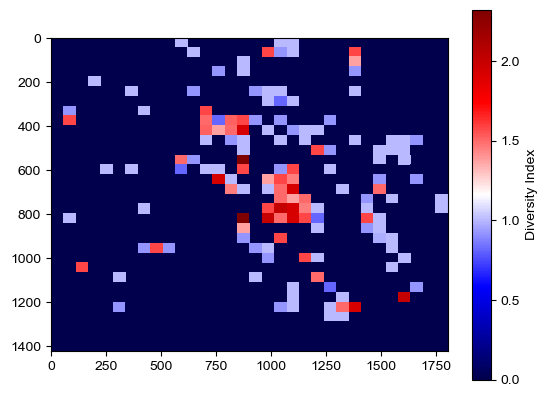

In [33]:
patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=protein, 
                                                                library_key='File Name', 
                                                                library_id=test_sample, 
                                                                spatial_key=['X:X','Y:Y'], 
                                                                patches=patches_coordinates, 
                                                                cluster_key='ClusterName', 
                                                                metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=protein,
                                          library_key='File Name',
                                          library_id=test_sample,
                                          spatial_key=['X:X','Y:Y'],
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=True,
                                          plot=True,
                                          return_fig=True)

In [34]:
n, m = grid.shape
w = weights.lat2W(n, m, rook=False)
lisa = esda.Moran_Local(grid.flatten(), w, transformation='r', permutations=999, seed=42) 

In [35]:
sum(lisa.p_sim<0.05)-sum(lisa.p_sim<0.01)

257

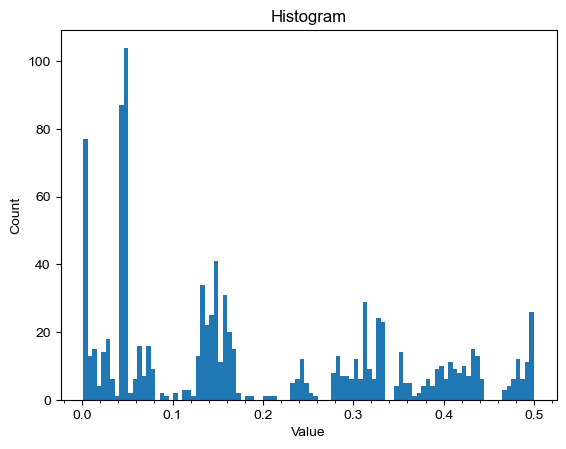

In [36]:
plt.hist(lisa.p_sim, bins=100)  # You can adjust the number of bins
 
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.show()

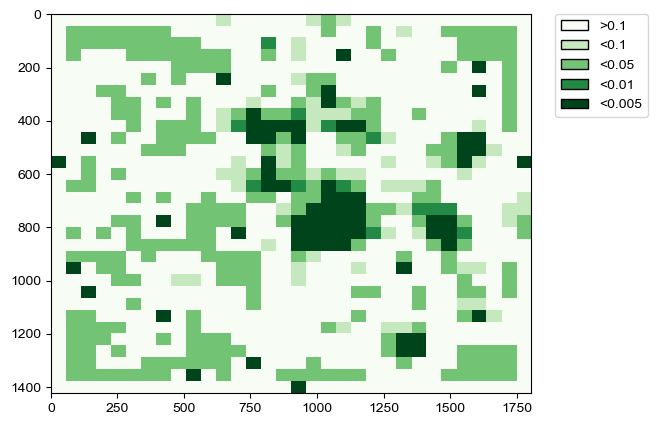

In [37]:
heatmap_fig = msd.pvalue_heatmap(spatial_data=protein,
                                 library_key='File Name', 
                                 library_id=test_sample,
                                 spatial_key=['X:X','Y:Y'],
                                 patches=patches_coordinates, 
                                 heterogeneity_indices=pd.Series(lisa.p_sim),
                                 tissue_only=False,
                                 plot=True,
                                 discrete=True,
                                 return_fig=True)
heatmap_fig.tight_layout()
save_path = '../figures/crc/crc_'+ test_sample + '_lisa_sigmap.svg'
heatmap_fig.savefig(save_path)

In [15]:
test_scale = 32.0
pvalue_diff_df = pd.DataFrame(columns=["Region", "P_Value_Difference", "Group"])
for region in protein['File Name'].unique():
    patches_coordinates = msd.generate_patches(protein, 'File Name', region, scaling_factor=test_scale, spatial_key=['X:X','Y:Y'])
    patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=protein, 
                                                                library_key='File Name', 
                                                                library_id=region, 
                                                                spatial_key=['X:X','Y:Y'], 
                                                                patches=patches_coordinates, 
                                                                cluster_key='ClusterName', 
                                                                metric='Shannon Diversity', return_comp=True)


    # Visualize the heterogeneity indices
    grid = msd.diversity_heatmap(spatial_data=protein,
                                 library_key='File Name',
                                 library_id=region,
                                 spatial_key=['X:X','Y:Y'],
                                 patches=patches_coordinates, 
                                 heterogeneity_indices=patch_indices,
                                 tissue_only=True,
                                 plot=False,
                                 return_fig=False)
    
    # Get group for the current region
    group = protein.loc[protein['File Name'] == region, 'groups'].iloc[0]
    
    n, m = grid.shape
    w = weights.lat2W(n, m, rook=False)
    lisa = esda.Moran_Local(grid.flatten(), w, transformation='r', permutations=999, seed=42) 
    p_value_difference = (sum(lisa.p_sim < 0.05) - sum(lisa.p_sim < 0.01))/sum(lisa.p_sim < 0.01)
    
    # Append the results to the DataFrame
    temp_df = pd.DataFrame({"Region": [region], "P_Value_Difference": [p_value_difference], "Group": [group]})
    pvalue_diff_df = pd.concat([pvalue_diff_df, temp_df], ignore_index=True)


46.875 per cent patches are empty


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_81785/2368483724.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvalue_diff_df = pd.concat([pvalue_diff_df, temp_df], ignore_index=True)


75.684 per cent patches are empty
46.094 per cent patches are empty
19.238 per cent patches are empty
46.875 per cent patches are empty
44.043 per cent patches are empty
35.645 per cent patches are empty
17.871 per cent patches are empty
18.359 per cent patches are empty
40.625 per cent patches are empty
37.695 per cent patches are empty
23.926 per cent patches are empty
17.188 per cent patches are empty
26.855 per cent patches are empty
49.609 per cent patches are empty
8.789 per cent patches are empty
12.988 per cent patches are empty
6.543 per cent patches are empty
25.586 per cent patches are empty
42.383 per cent patches are empty
30.762 per cent patches are empty
51.660 per cent patches are empty
32.910 per cent patches are empty
77.148 per cent patches are empty
25.098 per cent patches are empty
20.020 per cent patches are empty
50.098 per cent patches are empty
21.191 per cent patches are empty
17.188 per cent patches are empty
31.055 per cent patches are empty
27.637 per cent 

In [16]:
# Sort the DataFrame by 'Group'
pvalue_diff_df = pvalue_diff_df.sort_values(by='Group')

In [29]:
pvalue_diff_df[pvalue_diff_df['P_Value_Difference']>3]

,Region,P_Value_Difference,Group
132,reg067_A,3.134146,1
124,reg063_A,4.272727,1
85,reg043_B,4.559524,2


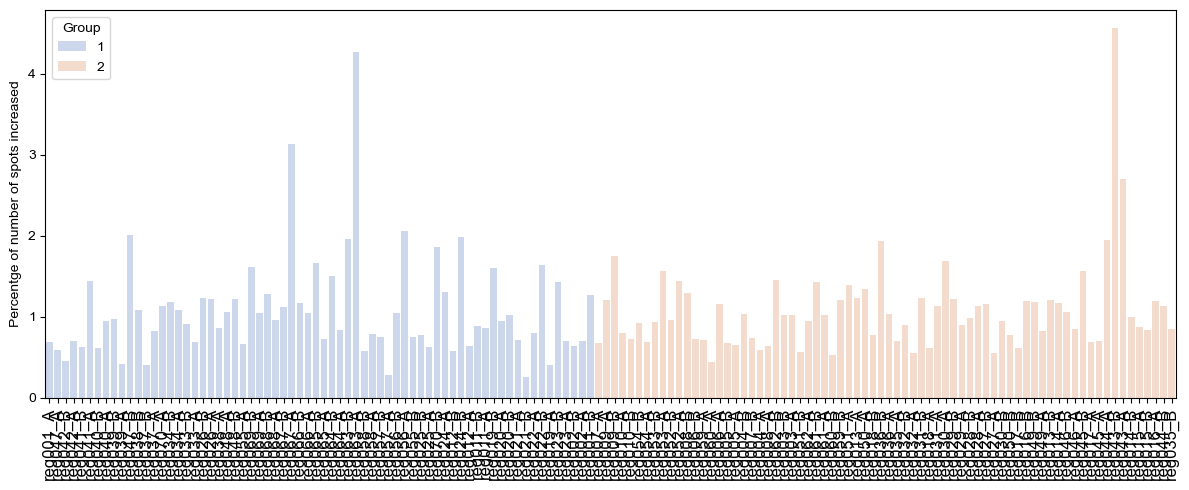

In [27]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(x='Region', y='P_Value_Difference', hue='Group', data=pvalue_diff_df, palette='muted', alpha=0.3)

# Set labels and title
ax.set_xlabel('')
ax.set_ylabel('Percentge of number of spots increased')
plt.xticks(rotation=90, fontsize=12)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# Determine quadrat scale

In [13]:
# Define the sequence of scales
scales = [2., 4., 8., 16., 24., 32., 48., 64., 72.]

In [14]:
# Perform Multiscale Diversity Analysis
library_names = ['CLR', 'DII'] 
metric_results = []
for library, library_name in zip(library_ids, library_names):
    df_scales, df_slopes = msd.multiscale_diversity(spatial_data=protein,
                                                    scales=scales,
                                                    library_key='File Name',
                                                    library_ids=library,
                                                    spatial_key=['X:X','Y:Y'],
                                                    cluster_key='ClusterName',
                                                    mode='M',
                                                    random_patch=False,
                                                    plotfigs=False,
                                                    savefigs=False,
                                                    patch_kwargs={'max_overlap':0.5,'random_seed': 42, 'min_points':2},
                                                    other_kwargs={'metric': 'Shannon Diversity'})
    
    df_metric = pd.concat([df_scales,df_slopes]).astype('float32')
    print(df_metric.head())
    averaged_metric = pd.DataFrame()  
    
    keys = list(df_metric.columns)
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            metric_list = df_metric[selected_keys]
            averaged_metric[patient] = np.array(metric_list).max(axis=1) # mean for MHI; max for GDI
            
    averaged_metric['Condition'] = library_name  
    metric_results.append(averaged_metric)  

Processing region: reg001_A at scale 2.0
0.000 per cent patches are empty
reg001_A at scale 2.0 has 0 patches with zero diveristy
reg001_A at scale 2.0 diversity is 3.006720259484636
Processing region: reg001_B at scale 2.0
0.000 per cent patches are empty
reg001_B at scale 2.0 has 0 patches with zero diveristy
reg001_B at scale 2.0 diversity is 3.0782022986901705
Processing region: reg002_A at scale 2.0
0.000 per cent patches are empty
reg002_A at scale 2.0 has 0 patches with zero diveristy
reg002_A at scale 2.0 diversity is 2.907866052919977
Processing region: reg002_B at scale 2.0
0.000 per cent patches are empty
reg002_B at scale 2.0 has 0 patches with zero diveristy
reg002_B at scale 2.0 diversity is 1.0846680190412177
Processing region: reg011_A at scale 2.0
0.000 per cent patches are empty
reg011_A at scale 2.0 has 0 patches with zero diveristy
reg011_A at scale 2.0 diversity is 2.9854848615599265
Processing region: reg011_B at scale 2.0
0.000 per cent patches are empty
reg011_B

In [15]:
# Combine results into single dataframe
df_final = pd.concat(metric_results).T
clr_final = df_final.iloc[:df_final.index.get_loc('Condition')].dropna(axis=1, how='all')
clr_final['Condition'] = 'CLR'
dii_final = df_final.iloc[df_final.index.get_loc('Condition')+1:].dropna(axis=1, how='all')
dii_final['Condition'] = 'DII'
df_results = pd.concat([clr_final, dii_final])
df_results.columns = scales+['Metric_Slope','Condition']
df_results['Sample_id'] = df_results.index
df_results

,2.0,4.0,8.0,16.0,24.0,32.0,48.0,64.0,72.0,Metric_Slope,Condition,Sample_id
1,-0.333333,0.265996,0.48133,0.653945,0.536351,0.429751,0.249583,0.084402,0.030135,-0.032809,CLR,1
6,-0.333333,0.385274,0.570914,0.61025,0.614264,0.506903,0.284822,0.10405,0.054788,-0.01083,CLR,6
10,-0.333333,0.375449,0.500484,0.616395,0.55893,0.530189,0.309713,0.12657,0.041742,-0.014243,CLR,10
11,-0.333333,0.254617,0.422783,0.595666,0.561323,0.512197,0.319585,0.132562,0.077044,-0.040075,CLR,11
12,-0.333333,0.290103,0.490346,0.47917,0.447034,0.360642,0.186975,0.05653,0.036553,-0.007438,CLR,12
13,-0.333333,0.23178,0.320979,0.561386,0.537345,0.458554,0.241923,0.082513,0.063832,-0.042398,CLR,13
17,-0.333333,0.350666,0.40724,0.518177,0.504092,0.426257,0.196913,0.099487,0.057869,-0.019798,CLR,17
19,-0.333333,0.311724,0.414214,0.517657,0.530521,0.442624,0.24082,0.111727,0.079033,-0.040574,CLR,19
20,-0.333333,0.059724,0.323085,0.527343,0.541372,0.485991,0.273654,0.086025,0.05362,-0.041999,CLR,20
21,-0.333333,0.517133,0.334926,0.459136,0.41447,0.329835,0.10952,0.045726,0.024866,-0.010565,CLR,21


In [30]:
df_melted = pd.melt(df_results, id_vars=['Sample_id', 'Condition'], value_vars=scales, 
                    var_name='Scale', value_name='Diversity Value')
df_melted['sample'] = 'Tissue Sample'
df_melted['Diversity Value'] = df_melted['Diversity Value'].fillna(0.0)
df_melted

,Sample_id,Condition,Scale,Diversity Value,sample
0,1,CLR,2.0,-0.333333,Tissue Sample
1,6,CLR,2.0,-0.333333,Tissue Sample
2,10,CLR,2.0,-0.333333,Tissue Sample
3,11,CLR,2.0,-0.333333,Tissue Sample
4,12,CLR,2.0,-0.333333,Tissue Sample
...,...,...,...,...,...
310,25,DII,72.0,0.015276,Tissue Sample
311,26,DII,72.0,0.016611,Tissue Sample
312,27,DII,72.0,0.029162,Tissue Sample
313,30,DII,72.0,0.006350,Tissue Sample


In [54]:
xrange = []
yrange = []
for region in protein['Region'].unique():
    xrange.append(protein[protein['Region']==region]['X:X'].max() - protein[protein['Region']==region]['X:X'].min())
    yrange.append(protein[protein['Region']==region]['Y:Y'].max() - protein[protein['Region']==region]['Y:Y'].min())
mean_xrange = np.mean(xrange)
std_xrange = np.std(xrange)
mean_yrange = np.mean(yrange)
std_yrange = np.std(yrange)

print(mean_xrange)
print(std_xrange)
print('-'*31)
print(mean_yrange)
print(std_yrange)

1884.3285714285714
42.65131765794796
-------------------------------
1435.4571428571428
11.55197659560069


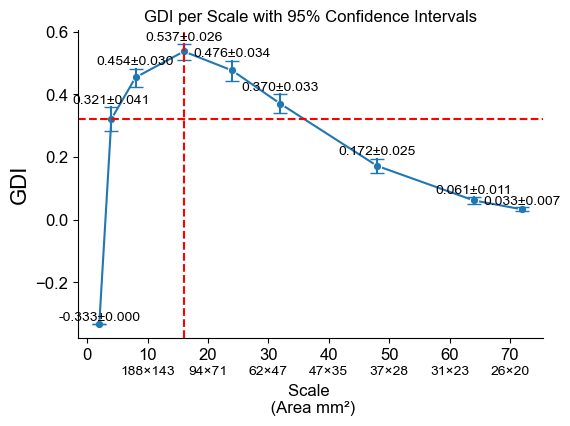

In [97]:
# Calculate mean and confidence interval manually
grouped = df_melted.groupby('Scale')
mean_values = grouped['Diversity Value'].mean()
conf_intervals = grouped['Diversity Value'].apply(lambda x: stats.sem(x) * stats.t.ppf((1 + 0.95) / 2., len(x)-1))

# Plotting using sns.lineplot
plt.figure(figsize=(6, 4))
ax = sns.lineplot(data=df_melted, 
                  x='Scale', 
                  y='Diversity Value', 
                  style='sample',
                  markers=True,
                  estimator='mean', 
                  err_style='bars', 
                  errorbar=("ci", 95),
                  err_kws={"capsize":5.0}
                 )

# Annotating error bars with their value
for i, (scale, mean, ci) in enumerate(zip(mean_values.index, mean_values, conf_intervals)):
    ax.text(scale, mean + ci, f'{mean:.3f}±{ci:.3f}', color='black', ha='center', va='bottom')
    
# Drawing red dashed horizontal lines at half the maximum of x and y axes
mean_diversity_per_scale = df_melted.groupby('Scale')['Diversity Value'].mean()
# y_sep = mean_diversity_per_scale.max() / 2
y_sep = mean_diversity_per_scale.median()
x_sep = mean_diversity_per_scale.idxmax()
# y_sep = df_melted.iloc[df_melted['Diversity Value'].idxmax()]['Diversity Value']/2
# x_sep = df_melted.iloc[df_melted['Diversity Value'].idxmax()]['Scale']

y_sep = mean_diversity_per_scale.median()
ax.axhline(y_sep, color='red', linestyle='--')
ax.axvline(x_sep, color='red', linestyle='--')

# Remove the legend
ax.get_legend().remove()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('', fontsize=0)
plt.xticks(fontsize=12)
plt.ylabel(f"GDI", fontsize=16)
plt.yticks(fontsize=12)

# Add secondary x-axis
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()][2:-1]
scales = [int(label) for label in xtick_labels if label.strip() != '']
x_sizes = [mean_xrange / scale for scale in scales]
y_sizes = [mean_yrange / scale for scale in scales]
size_labels = [f"{int(x_size)}×{int(y_size)}" for x_size, y_size in zip(x_sizes, y_sizes)]
secax = ax.secondary_xaxis(location=-0.075)
secax.set_xticks(scales)
secax.set_xticklabels(size_labels)
secax.tick_params('x', length=0)
secax.spines['bottom'].set_linewidth(0)
secax.set_xlabel(f'Scale \n (Area μm²)', fontsize=12)

plt.title(f'GDI per Scale with 95% Confidence Intervals')
plt.grid(False)
fig = plt.gcf()
fig.savefig('../figures/crc/crc_scale_selection.svg')
plt.show()


In [90]:
# Retrieve scales from x-axis labels
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()][1:-1]
# Convert labels to floats (ensure they are numerical and non-empty)
scales = [float(label) for label in xtick_labels if label.strip() != '']

In [94]:
[tick.get_text() for tick in ax.get_xticklabels()][2:-1]

['10', '20', '30', '40', '50', '60', '70']

# Global Cell-type Frequency

In [18]:
cluster_key = 'ClusterName'    

In [19]:
count_df = protein.groupby(['File Name', cluster_key, 'groups']).size().reset_index(name='count')
total_cells_in_region = protein.groupby('File Name').size().reset_index(name='total')

# Merge the two dataframes on the 'File Name' column
merged_df = pd.merge(count_df, total_cells_in_region, on='File Name')

# Compute the proportion for each cell type in each region
merged_df['Frequency'] = merged_df['count'] / merged_df['total']

# Getting unique values for combinations
unique_files = protein['File Name'].unique()
unique_clusters = protein[cluster_key].unique()

# Create a DataFrame from all combinations of the unique values for File Name and ClusterName
all_combinations = pd.DataFrame(pd.MultiIndex.from_product([unique_files, unique_clusters], 
                                                          names=['File Name', cluster_key]).tolist(), columns=['File Name', cluster_key])

# Merge the created DataFrame with merged_df, filling in missing values
proportion_df = pd.merge(all_combinations, merged_df, on=['File Name', cluster_key], how='left')
proportion_df['Frequency'].fillna(0, inplace=True)
# proportion_df.dropna(subset=['Frequency'], inplace=True)

proportion_df['groups'] = proportion_df['File Name'].map(merged_df.drop_duplicates('File Name').set_index('File Name')['groups'])

print(proportion_df)

     File Name           ClusterName  groups  count   total  Frequency
0     reg001_A          granulocytes       1   80.0  1095.0   0.073059
1     reg001_A           vasculature       1  104.0  1095.0   0.094977
2     reg001_A  CD4+ T cells CD45RO+       1  134.0  1095.0   0.122374
3     reg001_A           tumor cells       1   48.0  1095.0   0.043836
4     reg001_A                stroma       1  180.0  1095.0   0.164384
...        ...                   ...     ...    ...     ...        ...
3775  reg070_B            lymphatics       1    NaN     NaN   0.000000
3776  reg070_B      CD11b+ monocytes       1    NaN     NaN   0.000000
3777  reg070_B   CD4+ T cells GATA3+       1    NaN     NaN   0.000000
3778  reg070_B    CD163+ macrophages       1    NaN     NaN   0.000000
3779  reg070_B          CD3+ T cells       1    NaN     NaN   0.000000

[3780 rows x 6 columns]


In [20]:
# Melt the dictionary into a dataframe
patient_df = pd.DataFrame([(k, region) for k, regions in patient_to_region.items() for region in regions], columns=['Patient', 'File Name'])

# Merge the proportion_df with the patient dataframe
temp = pd.merge(proportion_df, patient_df, on='File Name')
patient_avg = temp.groupby(['Patient', cluster_key, 'groups'])['Frequency'].mean().reset_index()
print(patient_avg)


     Patient                 ClusterName  groups  Frequency
0          1                     B cells       1   0.028954
1          1            CD11b+ monocytes       1   0.000000
2          1     CD11b+CD68+ macrophages       1   0.001693
3          1                  CD11c+ DCs       1   0.002980
4          1          CD163+ macrophages       1   0.000000
..       ...                         ...     ...        ...
940       35               smooth muscle       1   0.048930
941       35                      stroma       1   0.114075
942       35                 tumor cells       1   0.247418
943       35  tumor cells / immune cells       1   0.007591
944       35                 vasculature       1   0.054358

[945 rows x 4 columns]


In [56]:
global_cell_count = patient_avg.pivot(index='Patient', columns=['ClusterName'], values='Frequency')
patient_conditions = patient_avg[['Patient', 'groups']].drop_duplicates().set_index('Patient')
patient_conditions.rename(columns={'groups': 'Condition'}, inplace=True)
global_cell_count = global_cell_count.join(patient_conditions)
# Define the mapping from numerical values to strings
condition_mapping = {1: 'CLR', 2: 'DII'}
global_cell_count['Condition'] = global_cell_count['Condition'].map(condition_mapping)
global_cell_count.head()

,B cells,CD11b+ monocytes,CD11b+CD68+ macrophages,CD11c+ DCs,CD163+ macrophages,CD3+ T cells,CD4+ T cells,CD4+ T cells CD45RO+,CD4+ T cells GATA3+,CD68+ macrophages,...,immune cells / vasculature,lymphatics,nerves,plasma cells,smooth muscle,stroma,tumor cells,tumor cells / immune cells,vasculature,Condition
Patient,,,,,,,,,,,,,,,,,,,,,
1,0.028954,0.000000,0.001693,0.002980,0.000000,0.000000,0.007312,0.047802,0.0000,0.000831,...,0.002531,0.000648,0.003232,0.039132,0.101803,0.084822,0.256125,0.002664,0.087537,CLR
2,0.020478,0.000599,0.026894,0.001406,0.000000,0.000000,0.008261,0.050557,0.0002,0.006495,...,0.000000,0.000132,0.000661,0.010696,0.064127,0.062411,0.211533,0.000576,0.026889,DII
3,0.014617,0.000250,0.011095,0.020367,0.000098,0.000365,0.001413,0.029137,0.0000,0.016229,...,0.000672,0.001251,0.003845,0.007921,0.209002,0.041120,0.187652,0.001013,0.058789,DII
4,0.002597,0.000075,0.006389,0.000528,0.000215,0.000000,0.000183,0.053418,0.0000,0.009043,...,0.000468,0.000108,0.000608,0.061013,0.051184,0.060779,0.273221,0.000828,0.038529,DII
5,0.019998,0.000226,0.060085,0.000670,0.000200,0.000122,0.000562,0.086683,0.0000,0.002829,...,0.000322,0.002507,0.008385,0.009428,0.247512,0.091049,0.042443,0.001201,0.083031,DII


# Calculate cell hot spots frequency

In [11]:
Hot = False 
p_value_cutoff = 0.05
library_names = ['CLR', 'DII'] 

total_merged_series = []
moran_results = {}

comp_results = []
comp_results_patient = []

comb_freq_results = []
comb_freq_results_patient = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=protein, 
                                                                              scale=32.0, 
                                                                              library_key='File Name',
                                                                              library_ids=library, 
                                                                              spatial_key=['X:X','Y:Y'],
                                                                              cluster_key='ClusterName',
                                                                              hotspot=Hot,
                                                                              p_value=p_value_cutoff,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              restricted=False,
                                                                              metric='Shannon Diversity')
    
    # Concatenate all the merged_series and sum across rows
    total_merged_series.append(total_comp_dict)
    # total_merged_series = pd.concat(total_comp_dict.values(), axis=1).sum(axis=1)
    # comp_results.append(total_merged_series)    
    comb_freq_results.append(spot_comb_dict)
    
    # create a dictionary to store cell composition in hot/cold spots, Moran's I
    comp_patient = pd.DataFrame()
    comb_patient = pd.DataFrame()
    moran_patient = {}
    
    keys = list(total_comp_dict.keys())
    
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            # list to store the selected series
            series_list = [total_comp_dict[key] for key in selected_keys]
            moran_list = [global_morans[key] for key in selected_keys]
            comb_series_list = [spot_comb_dict[key] for key in selected_keys]

            # calculate the average
            patient_series = pd.concat(series_list, axis=1).fillna(0)
            patient_comb_series = pd.concat(comb_series_list, axis=1).fillna(0)
            
            average_series = compute_average_frequency(patient_series)
            average_comb_series = patient_comb_series.mean(axis=1) # calculate cell combination freq in hotspots
            # moran_patient.append(np.array(moran_list).max())
            moran_patient[patient] = np.array(moran_list).max()
            
            # store the average in the output DataFrame
            comp_patient = append_series_to_df(comp_patient, average_series, patient)
            comb_patient = append_series_to_df(comb_patient, average_comb_series, patient)
            
    comp_patient = comp_patient.T    
    comp_patient['Condition'] = library_name 
    comp_results_patient.append(comp_patient.fillna(0))
    
    comb_patient = comb_patient.T
    comb_patient['Condition'] = library_name
    comb_freq_results_patient.append(comb_patient.fillna(0))
    
    # Store Moran's I 
    moran_results[library_name] = moran_patient

Processing region: reg001_A at scale 32.0
46.582 per cent patches are empty
Using MoranI
Region reg001_A contains 0 diversity coldspots
Region reg001_A has no diversity hot/cold spot since length of filtered_patches_comp is either 0 or hot/cold spots contain no cells
Processing region: reg001_B at scale 32.0
75.293 per cent patches are empty
Using MoranI
Region reg001_B contains 605 diversity coldspots
Considering only hotspots
Processing region: reg002_A at scale 32.0
45.996 per cent patches are empty
Using MoranI
Region reg002_A contains 270 diversity coldspots
Considering only hotspots
Processing region: reg002_B at scale 32.0
19.238 per cent patches are empty
Using MoranI
Region reg002_B contains 0 diversity coldspots
Region reg002_B has no diversity hot/cold spot since length of filtered_patches_comp is either 0 or hot/cold spots contain no cells
Processing region: reg011_A at scale 32.0
30.371 per cent patches are empty
Using MoranI
Region reg011_A contains 291 diversity coldspot

## process and visualise cell frequency

In [12]:
df1 = comp_results_patient[0]
df2 = comp_results_patient[1]

# get the union of columns
columns = df1.columns.union(df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
df1 = df1.reindex(columns=columns).fillna(0)
df2 = df2.reindex(columns=columns).fillna(0)

28


In [15]:
scaler = MinMaxScaler()
df_abundance = pd.concat([df1, df2],axis=0)
df_abundance['Patient'] = df_abundance.index

# Drop some cols
# low_var_cols =  ['CD163+ macrophages', 'CD4+ T cells GATA3+', 'NK cells',
#                  'CD68+ macrophages GzmB+', 'lymphatics']
# df_abundance.drop(columns=low_var_cols,inplace=True)

# Only include some cols
cols_include = ['B cells' , 'Tregs', 'CD4+ T cells', 'CD4+ T cells CD45RO+', 
                'CD68+CD163+ macrophages' ,'CD8+ T cells', 'Condition', 'Patient']
df_abundance = df_abundance[cols_include]

df_abundance.head()

,B cells,Tregs,CD4+ T cells,CD4+ T cells CD45RO+,CD68+CD163+ macrophages,CD8+ T cells,Condition,Patient
1,0.000000,0.041667,0.000000,0.057796,0.153898,0.008065,CLR,1
6,0.025641,0.023203,0.000000,0.000000,0.063713,0.026144,CLR,6
10,0.000000,0.003571,0.000000,0.207438,0.057063,0.007143,CLR,10
11,0.040476,0.000000,0.022222,0.197619,0.161111,0.078571,CLR,11
12,0.000000,0.006579,0.000000,0.072734,0.092105,0.078947,CLR,12


# Survival Analysis

In [52]:
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FixedLocator
from sklearn.cluster import KMeans

## Hot spot cell type freq

In [19]:
dii_final = df_abundance[df_abundance['Condition']=='DII'].copy()

columns_to_normalize = dii_final.columns[:-2]
dii_final[columns_to_normalize] = scaler.fit_transform(dii_final[columns_to_normalize])

df_combined = pd.merge(dii_final, meta_df[['Patient','OS','OS_Censor']], on='Patient', how='inner')
df_combined = df_combined[df_combined['Condition']=='DII']
df_combined

,B cells,Tregs,CD4+ T cells,CD4+ T cells CD45RO+,CD68+CD163+ macrophages,CD8+ T cells,Condition,Patient,OS,OS_Censor
0,0.240176,0.000000,0.000000,0.000000,0.000000,0.000000,DII,2,137.640,0.0
1,0.000000,1.000000,0.000000,0.000000,0.425513,1.000000,DII,3,0.394,1.0
2,0.000000,0.000000,0.000000,0.316618,0.266664,0.000000,DII,4,0.526,1.0
3,0.000000,0.644225,0.766169,0.026419,0.184088,0.184007,DII,5,43.458,1.0
4,0.000000,0.676961,0.000000,1.000000,0.177402,0.000000,DII,7,68.179,0.0
5,0.000000,0.506787,0.000000,0.037886,0.405602,0.222529,DII,8,21.236,1.0
6,0.012550,0.000000,0.000000,0.064739,0.415665,0.101203,DII,9,12.788,1.0
7,0.090456,0.597902,1.000000,0.020950,0.538934,0.054555,DII,14,13.248,0.0
8,0.053993,0.000000,0.000000,0.043058,0.930804,0.026418,DII,15,0.296,1.0
9,0.000000,0.097410,0.000000,0.143292,0.581956,0.157213,DII,16,124.622,0.0


In [20]:
feature = dii_final.columns[:-2].to_list()
cph = CoxPHFitter(penalizer=0.01,l1_ratio=1)

df_subset = df_combined[['OS', 'OS_Censor', 'Condition']+feature].copy()

scores = k_fold_cross_validation(cph, 
                                 df_subset[['OS', 'OS_Censor']+feature], 
                                 duration_col='OS', 
                                 event_col='OS_Censor', 
                                 k=5, 
                                 scoring_method="concordance_index",
                                 seed=0)
print(scores)
mean_score = np.mean(scores)
std_deviation = np.std(scores)

print(f"Mean Concordance Index: {mean_score:.3f}")
print(f"Standard Deviation: {std_deviation:.3f}")

[0.6666666666666666, 0.16666666666666666, 0.16666666666666666, 0.0, 0.6666666666666666]
Mean Concordance Index: 0.333
Standard Deviation: 0.279


In [21]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 15 total observations, 4 right-censored observations>
             duration col = 'OS'
                event col = 'OS_Censor'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 15
number of events observed = 11
   partial log-likelihood = -19.67
         time fit was run = 2024-10-09 16:02:54 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
B cells                   1.17       3.23       1.85            -2.45             4.79                 0.09               120.59
Tregs                    -0.44       0.64       1.73            -3.84             2.95                 0.02                19.15
CD4+ T cells             -1.43       0.24       1.57            -4.50             1.64                 0.01                 5.14
CD4+ T cells CD45RO+     -1.08       0.34       2.04            -5.07             2.92                 0.01                18.51
CD68+CD163+ macrophages   2.04       7.71       1.35            -0.61             4.70                 0.54               109.46
CD8+ T cells              2.95      19.07       3.21            -3.34             9.23                 0.04             10223.24

                          cmp to     z    p   -log2(p)
covariate                                             
B cells                     0.00  0.63 0.53       0.93
Tregs                       0.00 -0.26 0.80       0.33
CD4+ T cells                0.00 -0.91 0.36       1.47
CD4+ T cells CD45RO+        0.00 -0.53 0.60       0.74
CD68+CD163+ macrophages     0.00  1.51 0.13       2.93
CD8+ T cells                0.00  0.92 0.36       1.48
---
Concordance = 0.70
Partial AIC = 51.34
log-likelihood ratio test = 7.46 on 6 df
-log2(p) of ll-ratio test = 1.84

## Calculate Multi-Scale Homogeneity Index

In [15]:
# Define the sequence of scales
scales = [1., 2., 4., 8., 16.]
# scales = [2., 4., 8., 16., 32., 48., 64.] # for scale selection with multi-scale GDI

In [16]:
# Perform Multiscale Diversity Analysis
library_names = ['CLR', 'DII'] 
metric_results = []
for library, library_name in zip(library_ids, library_names):
    df_scales, df_slopes = msd.multiscale_diversity(spatial_data=protein,
                                                    scales=scales,
                                                    library_key='File Name',
                                                    library_ids=library,
                                                    spatial_key=['X:X','Y:Y'],
                                                    cluster_key='ClusterName',
                                                    mode='D',
                                                    random_patch=False,
                                                    plotfigs=False,
                                                    savefigs=False,
                                                    patch_kwargs={'max_overlap':0.5,'random_seed': 42, 'min_points':2},
                                                    other_kwargs={'metric': 'Shannon Diversity'})
    
    df_metric = pd.concat([df_scales,df_slopes]).astype('float32')
    print(df_metric.head())
    averaged_metric = pd.DataFrame()  
    
    keys = list(df_metric.columns)
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            metric_list = df_metric[selected_keys]
            averaged_metric[patient] = np.array(metric_list).mean(axis=1) # mean for MHI; max for GDI
            
    averaged_metric['Condition'] = library_name  
    metric_results.append(averaged_metric)  

Processing region: reg001_A at scale 1.0
0.000 per cent patches are empty
reg001_A at scale 1.0 has 0 patches with zero diveristy
reg001_A at scale 1.0 diversity is 3.3164164900586974
Processing region: reg001_B at scale 1.0
0.000 per cent patches are empty
reg001_B at scale 1.0 has 0 patches with zero diveristy
reg001_B at scale 1.0 diversity is 3.354147234904591
Processing region: reg002_A at scale 1.0
0.000 per cent patches are empty
reg002_A at scale 1.0 has 0 patches with zero diveristy
reg002_A at scale 1.0 diversity is 3.151848682137609
Processing region: reg002_B at scale 1.0
0.000 per cent patches are empty
reg002_B at scale 1.0 has 0 patches with zero diveristy
reg002_B at scale 1.0 diversity is 1.1192231346242458
Processing region: reg011_A at scale 1.0
0.000 per cent patches are empty
reg011_A at scale 1.0 has 0 patches with zero diveristy
reg011_A at scale 1.0 diversity is 3.1236111964254585
Processing region: reg011_B at scale 1.0
0.000 per cent patches are empty
reg011_B

In [17]:
# Combine results into single dataframe
df_final = pd.concat(metric_results).T
clr_final = df_final.iloc[:df_final.index.get_loc('Condition')].dropna(axis=1, how='all')
clr_final['Condition'] = 'CLR'
dii_final = df_final.iloc[df_final.index.get_loc('Condition')+1:].dropna(axis=1, how='all')
dii_final['Condition'] = 'DII'
df_results = pd.concat([clr_final, dii_final])
df_results.columns = scales+['Metric_Slope','Condition']
df_results['Sample_id'] = df_results.index
df_results

,1.0,2.0,4.0,8.0,16.0,Metric_Slope,Condition,Sample_id
1,2.735409,2.519364,2.196352,1.652484,1.005014,0.432767,CLR,1
6,3.091561,2.72638,2.352608,1.905939,1.37691,0.424974,CLR,6
10,2.865577,2.630261,2.250778,1.752131,1.264583,0.408012,CLR,10
11,3.030774,2.904184,2.505228,1.933249,1.249184,0.453412,CLR,11
12,2.496194,2.357985,2.168898,1.833694,1.287313,0.294205,CLR,12
13,3.10875,2.94518,2.713655,2.277876,1.617662,0.364948,CLR,13
17,2.632776,2.537832,2.399208,2.011313,1.506856,0.277836,CLR,17
19,2.889599,2.71975,2.446007,1.934817,1.280454,0.400322,CLR,19
20,2.934031,2.735336,2.422676,1.844559,1.286653,0.418553,CLR,20
21,2.066639,1.960674,1.759059,1.453351,0.985503,0.266959,CLR,21


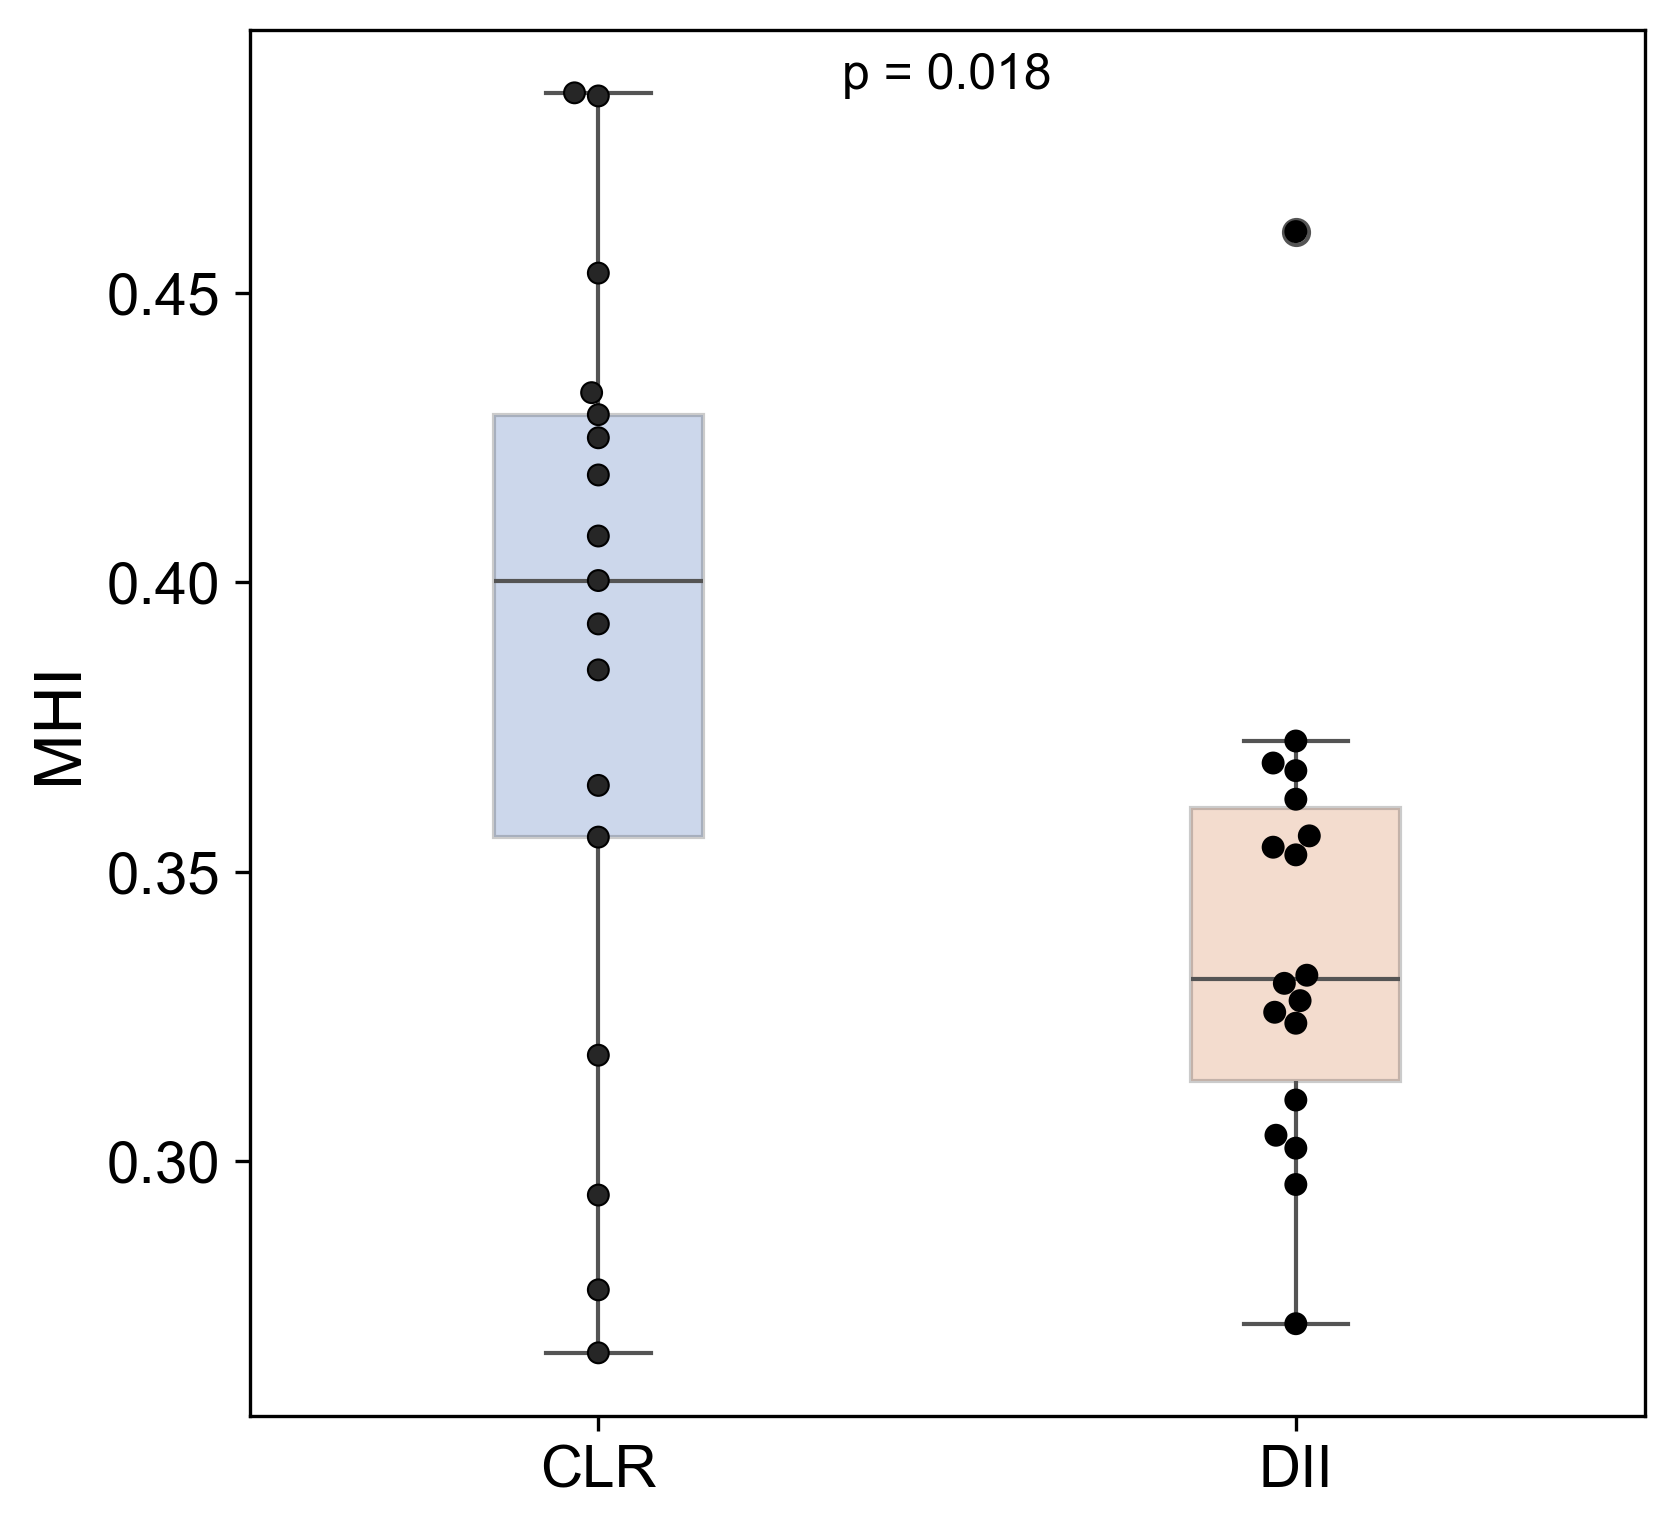

In [16]:
fig, ax = plt.subplots(figsize=(6, 6),dpi=300)

# Boxplot
sns.boxplot(data=df_results, x='Condition', y='Metric_Slope', hue='Condition', 
            ax=ax, palette="muted", width=0.3, boxprops=dict(alpha=.3), legend=False)

sns.swarmplot(data=df_results, x='Condition', 
              y='Metric_Slope', palette='dark:black', hue='Condition',
              linewidth=0.5, size=5, ax=ax, legend=False)

# Labeling and titling
ax.set_xlabel('', fontsize=14)  # Modify as necessary
ax.set_ylabel('MHI', fontsize=16)  # Modify as necessary
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Separate data into two conditions
data_condition_1 = clr_final[len(scales)].astype(np.float32)
data_condition_2 = dii_final[len(scales)].astype(np.float32)

# Perform Mann-Whitney U test
#U_stat, p_val = stats.mannwhitneyu(data_condition_1, data_condition_2, alternative='two-sided')
stat, p_val = stats.ttest_ind(data_condition_1, data_condition_2 ,equal_var=False)

ax.text(0.5, 0.95, f'p = {p_val:.3f}', 
        horizontalalignment='center', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=12)

save_path = 'MSDiversity_slope.svg'
fig = plt.gcf()
# fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)

## Cox Model

In [53]:
meta_path = '/Users/Emrys/Dropbox/spatial_augmentation/data/CRC_related/crc_codex/'
meta_df = pd.read_csv(os.path.join(meta_path, 'CRC_TMAs_patient_annotations.csv'))

In [54]:
# Convert 'Patient' column in meta_df to string
# Drop rows from 35 onwards where any NaN appears
meta_df = meta_df.loc[:34]

In [18]:
dii_final['Patient'] = dii_final.index
dii_final

,0,1,2,3,4,5,Condition,Patient
2,2.735204,2.620569,2.400419,2.023477,1.480671,0.310616,DII,2
3,3.031438,2.846666,2.56746,2.20253,1.582137,0.354274,DII,3
4,2.679496,2.401382,2.074035,1.760649,1.33903,0.332167,DII,4
5,3.054683,2.933089,2.708526,2.341326,1.721699,0.325773,DII,5
7,2.856732,2.665677,2.418124,1.990804,1.381371,0.36256,DII,7
8,2.562878,2.447626,2.250904,1.904271,1.354426,0.296026,DII,8
9,3.090887,2.841036,2.527657,2.144199,1.595249,0.368811,DII,9
14,3.004387,2.892924,2.712159,2.333473,1.761452,0.304532,DII,14
15,2.542124,2.307198,2.09686,1.776386,1.296025,0.302301,DII,15
16,3.200839,3.06839,2.832928,2.414936,1.76281,0.352951,DII,16


In [ ]:
df_combined = pd.merge(dii_final, meta_df[['Patient','OS','OS_Censor']], on='Patient', how='inner')
df_combined = df_combined[df_combined['Condition']=='DII']
df_combined

In [64]:
feature = [0,1,2,3,4]
feature = dii_final.columns[:-2].to_list()
cph = CoxPHFitter(penalizer=0.01,l1_ratio=1)

df_subset = df_combined[['OS', 'OS_Censor', 'Condition']+feature].copy()

scores = k_fold_cross_validation(cph, 
                                 df_subset[['OS', 'OS_Censor']+feature], 
                                 duration_col='OS', 
                                 event_col='OS_Censor', 
                                 k=5, 
                                 scoring_method="concordance_index",
                                 seed=0)
print(scores)

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['CD11b+CD68+ macrophages'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['CD11b+ monocytes', 'Tregs'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['CD4+ T cells'] have very low variance. This may harm convergence. 1) Are you using 

[0.6666666666666666, 0.6666666666666666, 0.5, 0.0, 0.3333333333333333]


In [30]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 15 total observations, 4 right-censored observations>
             duration col = 'OS'
                event col = 'OS_Censor'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 15
number of events observed = 11
   partial log-likelihood = -17.89
         time fit was run = 2024-10-09 15:10:29 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0          12.14   1.88e+05       8.48            -4.48            28.77                 0.01             3.11e+12
1          -4.75       0.01      11.78           -27.84            18.34                 0.00             9.27e+07
2         -19.29       0.00       8.91           -36.74            -1.83                 0.00                 0.16
3           0.00       1.00       0.15            -0.29             0.29                 0.75                 1.34
4          13.72   9.11e+05       6.03             1.90            25.55                 6.67             1.24e+11

            cmp to     z    p   -log2(p)
covariate                               
0             0.00  1.43 0.15       2.72
1             0.00 -0.40 0.69       0.54
2             0.00 -2.17 0.03       5.04
3             0.00  0.00 1.00       0.00
4             0.00  2.27 0.02       5.45
---
Concordance = 0.80
Partial AIC = 45.78
log-likelihood ratio test = 11.02 on 5 df
-log2(p) of ll-ratio test = 4.29

In [31]:
mean_score = np.mean(scores)
std_deviation = np.std(scores)

print(f"Mean Concordance Index: {mean_score:.3f}")
print(f"Standard Deviation: {std_deviation:.3f}")

Mean Concordance Index: 0.900
Standard Deviation: 0.133


# Find the optimal cut-off threshold that maximizes statistical significance

In [57]:
df_combined['risk_score'] = cph.predict_partial_hazard(df_combined)
df_combined

,0,1,2,3,4,5,Condition,Patient,OS,OS_Censor,risk_score
0,2.735204,2.620569,2.400419,2.023477,1.480671,0.310616,DII,2,137.640,0.0,0.436192
1,3.031438,2.846666,2.56746,2.20253,1.582137,0.354274,DII,3,0.394,1.0,0.873513
2,2.679496,2.401382,2.074035,1.760649,1.33903,0.332167,DII,4,0.526,1.0,48.686674
3,3.054683,2.933089,2.708526,2.341326,1.721699,0.325773,DII,5,43.458,1.0,0.343444
4,2.856732,2.665677,2.418124,1.990804,1.381371,0.36256,DII,7,68.179,0.0,0.280214
5,2.562878,2.447626,2.250904,1.904271,1.354426,0.296026,DII,8,21.236,1.0,0.386781
6,3.090887,2.841036,2.527657,2.144199,1.595249,0.368811,DII,9,12.788,1.0,4.763063
7,3.004387,2.892924,2.712159,2.333473,1.761452,0.304532,DII,14,13.248,0.0,0.363011
8,2.542124,2.307198,2.09686,1.776386,1.296025,0.302301,DII,15,0.296,1.0,5.125753
9,3.200839,3.06839,2.832928,2.414936,1.76281,0.352951,DII,16,124.622,0.0,0.170086


0.026591034765298036
5.1295097642645105e-05
The best p_value is 5.1295097642645105e-05


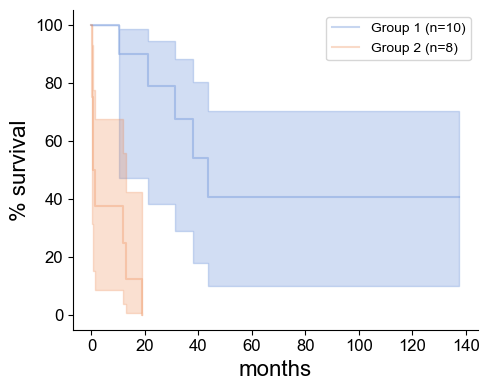

In [80]:
kmf = KaplanMeierFitter()

# Define all possible cutpoints
metric = 'risk_score' #'Frequency' # 'risk_score'
cutpoints = df_combined[metric].unique()

# Initialize best threshold
best_threshold = cutpoints[0]
best_p_value = 1.0

# Define p-value tolerance
p_value_tolerance = 0.0001

# Iterate over all possible cutpoints
for threshold in cutpoints:
    # Split the dataframe
    df_group1 = df_combined[df_combined[metric] < threshold]
    df_group2 = df_combined[df_combined[metric] >= threshold]

    # Calculate logrank_test p-value
    result = logrank_test(df_group1['OS'], df_group2['OS'], event_observed_A=df_group1['OS_Censor'], event_observed_B=df_group2['OS_Censor'])
    p_value = result.p_value
    print(p_value)
    
    # Update best_threshold if current p_value is smaller than best_p_value
    if p_value < best_p_value:
        best_p_value = p_value
        best_threshold = threshold
    
    # Stop the loop if p_value is less than the specified tolerance
    if p_value < p_value_tolerance:
        break

print(f"The best p_value is {best_p_value}")

# Set the color palette to "muted" and get the colors
sns.set_palette("muted")
colors = sns.color_palette()

# Split the dataframe using best_threshold
df_group1 = df_combined[df_combined[metric] < best_threshold]
df_group2 = df_combined[df_combined[metric] >= best_threshold]

# Fit the model for each group and use the colors
kmf = KaplanMeierFitter()
plt.figure(figsize=(5, 4))

# Plot for Group 1
kmf.fit(df_group1['OS'], df_group1['OS_Censor'], label=f'Group 1 (n={len(df_group1)})')
ax = kmf.plot_survival_function(color=colors[0], alpha=0.3)

# Plot for Group 2
kmf.fit(df_group2['OS'], df_group2['OS_Censor'], label=f'Group 2 (n={len(df_group2)})')
kmf.plot_survival_function(ax=ax, color=colors[1], alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the tick locations and convert y-axis values to percentages
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(FixedLocator(ticks_loc))
ax.set_yticklabels([f'{100 * y:.0f}' for y in ticks_loc])

# plt.title(f'Kaplan Meier Curves for different biomarker groups (threshold = {best_threshold})')
plt.xlabel('months', fontsize=16)
plt.ylabel('% survival', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
save_path = 'CRC' + str(metric) + '_survivalKM.svg'
fig = plt.gcf()
fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)


In [68]:
print(f"Group 1 has {len(df_group1)} patients")
print(f"Group 2 has {len(df_group2)} patients")

Group 1 has 10 patients
Group 2 has 8 patients


In [214]:
c_index = [[0.7333333333333333, 0.7857142857142857, 0.6153846153846154, 0.6176470588235294, 0.8333333333333334],
           [0.8666666666666667, 0.5714285714285714, 0.6923076923076923, 0.7058823529411765, 0.8333333333333334], 
           [0.8, 0.7857142857142857, 0.6923076923076923, 0.6470588235294118, 0.8888888888888888]]
covar = ['CLR/DII', 'MSD', 'MSD+CLR/DII']

In [246]:
from matplotlib.ticker import AutoMinorLocator

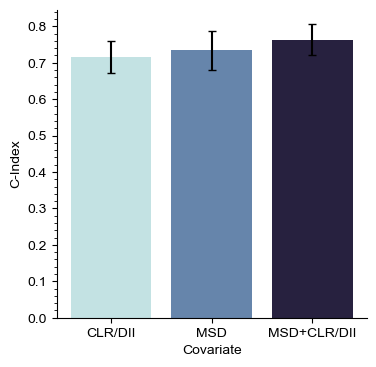

In [248]:
# Converting data into a pandas DataFrame for easier plotting with seaborn
data = []
for i, covariate in enumerate(covar):
    for c in c_index[i]:
        data.append({'Covariate': covariate, 'C-Index': c})
cindex_df = pd.DataFrame(data)

# Calculate mean and standard error of the mean (SEM) for each Covariate
group_stats = cindex_df.groupby('Covariate')['C-Index'].agg(['mean', 'sem']).reset_index()
gradient_palette = sns.color_palette("ch:start=.2,rot=-.3", len(group_stats))

# Plot
plt.figure(figsize=(4, 4))
plt.bar(group_stats['Covariate'], group_stats['mean'], yerr=group_stats['sem'], color=gradient_palette,capsize=3)
plt.xlabel('Covariate')
plt.ylabel('C-Index')
plt.title('')

# Get current axes and hide the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())

save_path = 'CRC_cindex.svg'
cindex_fig = plt.gcf()
cindex_fig.savefig('../figures/crc/' + save_path)

plt.show()
plt.close(cindex_fig)
